In [4]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc

def aucNth(y, yp, N):
    assert len(y) == len(yp)
    assert len(y) > 1
    fpr, tpr, thresholds = roc_curve(y, yp)
    negatives = y.count(0)
    assert N < negatives
    perc = N / float(negatives)
    fpr1k = []
    tpr1k = []
    i = 0
    while i < len(fpr):
        if fpr[i] > perc:
            break
        fpr1k.append(fpr[i])
        tpr1k.append(tpr[i])
        i+=1
    assert len(fpr1k) > 1
    aucScore = auc(fpr1k, tpr1k) / perc
    #print(aucScore,perc,auc(fpr1k, tpr1k),len(fpr),len(fpr1k),fpr1k[-1],fpr[-1],tpr[-1],tpr1k[-1])
    return aucScore

def load(fpath):
    with open(fpath,'r') as f:
        score = []
        real = []
        for l in f:
            l = l.rstrip().split()
            score.append(-float(l[2]))
            real.append(float(l[3]))
        return score,real

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import pickle
matplotlib.font_manager.FontProperties(family='Droid Sans Mono')

def load_pickle(fname):
    with open(fname,'rb') as f:
        return pickle.load(f)

def load_benchmark(method,db,max50=True,N=1000):
    if max50: path = 'benchmark/Bitscores_and_Evalues/ROC_plot_Bitscores_max50_1vs1_rank/'+method+'_'+db+'_max50_1vs1'
    else: path = 'benchmark/Bitscores_and_Evalues/ROC_plot_Bitscores_nomax50_1vs1_rank/'+method+'_'+db+'_nomax50_1vs1'
    sens = []
    spec = []
    at = []
    af = []
    with open(path,'r') as f:
        for line in f:
            line = line.strip().split()
            t = float(line[0])
            f = float(line[1])
            sens.append(t)
            spec.append(f)
            if f <= N:
                at.append(t)
                af.append(f)
    cnt = (len(sens)+1)/2
    sens = np.array(sens)/cnt
    spec = np.array(spec)/cnt
    at = np.array(at)/cnt
    af = np.array(af)/cnt
    aucScore = auc(spec,sens)
    aucN = auc(af,at)/(N/cnt)
    return spec,sens,aucScore,aucN


def load_prost(db,l1,n1,m1,l2,n2,m2,w1=1,w2=1):
    
    allr1,r = load('layer/results/allr.%s.%d.%d.res'%(l1,n1,m1))
    allr2,r = load('layer/results/allr.%s.%d.%d.res'%(l2,n2,m2))
    allr = (np.array(allr1)*w1+np.array(allr2)*w2)/2
    
    pfamp,pfamr = (allr[:10490],r[:10490])
    genep,gener = (allr[10490:10490+11312],r[10490:10490+11312])
    supfp,supfr = (allr[10490+11312:],r[10490+11312:])
    if db == 'pfam': 
        pr, r = pfamp,pfamr
    elif db == 'gene3d':
        pr, r = genep,gener
    else: 
        pr, r = supfp,supfr
    fpr, tpr, threshold = roc_curve(r, pr)
    aucScore = roc_auc_score(r,pr)
    aucp = aucNth(r, pr, 1000)
    return fpr,tpr,aucScore,aucp

def drawBenchmarkFigure(db):
    
    if db == 'pfam': 
        methods = ["PROST-L","PROST","csblast","phmmer","hhsearch","blast","ESM1bL34M","usearch","fasta","ublast"]
        colors = ["r--","r","#D95F0E","#EEAD0E","#4DAC26","#92C5DE",'black',"#636363","#D01C8B","#0eeead","#0eeead"]
        title = 'PFAM max50'
        esmPath = 'ESM1bL34M/pfam.res.pkl'
        prostLPath = 'prost-l/pfam.res.pkl'
    elif db == 'gene3d':
        methods = ["PROST","PROST-L","csblast","phmmer","hhsearch","blast","usearch","fasta","ublast","ESM1bL34M"]
        colors = ["r","r--","#D95F0E","#EEAD0E","#4DAC26","#92C5DE","#636363","#D01C8B","#0eeead",'black']
        title = 'CATH/Gene3D max50'
        esmPath = 'ESM1bL34M/gene3d.res.pkl'
        prostLPath = 'prost-l/gene3d.res.pkl'
    else: 
        methods = ["PROST-L","PROST","phmmer","csblast","hhsearch","blast","usearch","fasta","ESM1bL34M","ublast"]
        colors = ["r--","r","#EEAD0E","#D95F0E","#4DAC26","#92C5DE","#636363","#D01C8B","black",'#0eeead']
        title = 'SCOP/Superfamiliy max50'
        esmPath = 'ESM1bL34M/supfam.res.pkl'
        prostLPath = 'prost-l/supfam.res.pkl'
    
    plt.title(title)
    
    with open('benchmark/figs/%s.max50.txt'%db, 'w') as f:
        for i,m in enumerate(methods):
            if m == 'PROST-L':
                fpr,tpr,aucScore,aucp = load_prost(db,25,3,1280,13,3,1280)
            elif m == 'PROST':
                fpr,tpr,aucScore,aucp = load_prost(db,25,5,44,13,3,85)
            elif m == 'ESM1bL34M':
                fpr,tpr,aucScore,aucp = load_pickle(esmPath)
            else:
                fpr,tpr,aucScore,aucp = load_benchmark(m,db)
                
            plt.plot(fpr, tpr, colors[i], label = '%4.1f %s' % (aucp*100,m.upper()))
            f.write('%s\t%.4f\t%.4f\n'%(m.upper(),aucScore,aucp))
            
    plt.legend(loc = 'lower right',title='AUC1000 Scores',prop=matplotlib.font_manager.FontProperties(size=9))
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('benchmark/figs/%s.max50.png'%db, dpi=600)
    plt.savefig('benchmark/figs/%s.max50.svg'%db)
    plt.show()
    

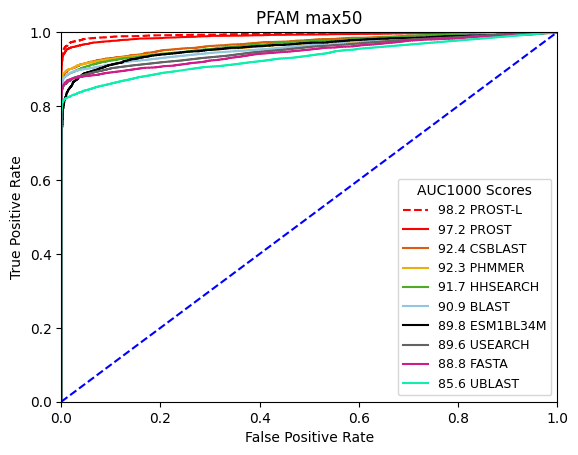

In [8]:
drawBenchmarkFigure('pfam')

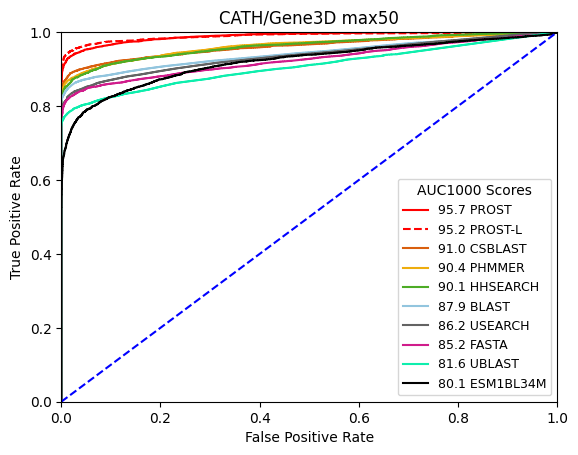

In [33]:
drawBenchmarkFigure('gene3d')

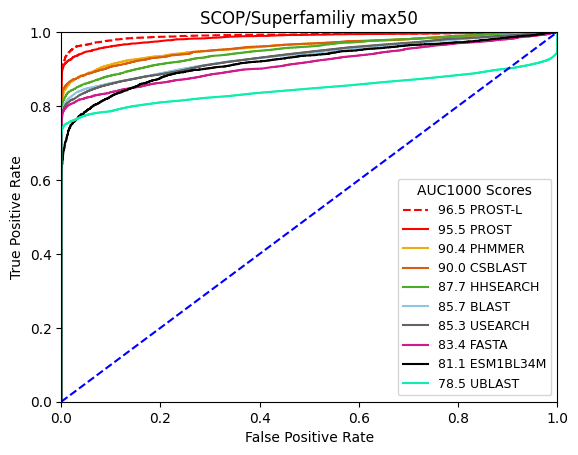

In [34]:
drawBenchmarkFigure('supfam')